In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.rename(columns = {'DEATH_EVENT': 'death_event'}, inplace = True)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

In [4]:
df.death_event.value_counts()

0    203
1     96
Name: death_event, dtype: int64

In [5]:
group = df.groupby('death_event').mean()
group

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
death_event,,,,,,,,,,,,
0,58.761906,0.408867,540.054187,0.418719,40.26601,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901
1,65.215281,0.479167,670.197917,0.416667,33.46875,0.406250,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417


### Exploring Each variable's relationship with the target variable (Death Event)

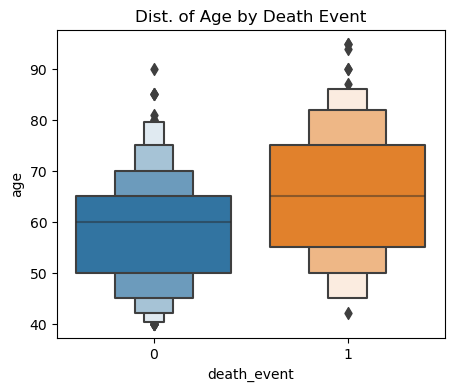

In [6]:
plt.figure(figsize = (5,4))

sns.boxenplot(data = df, x = 'death_event', y = 'age')
plt.title("Dist. of Age by Death Event")

plt.show()

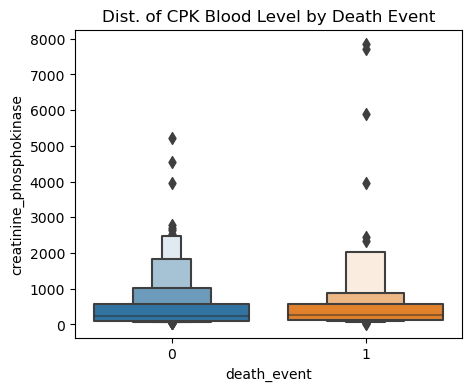

In [7]:
plt.figure(figsize = (5,4))

sns.boxenplot(data =df, x = 'death_event', y = 'creatinine_phosphokinase')
plt.title("Dist. of CPK Blood Level by Death Event")

plt.show()

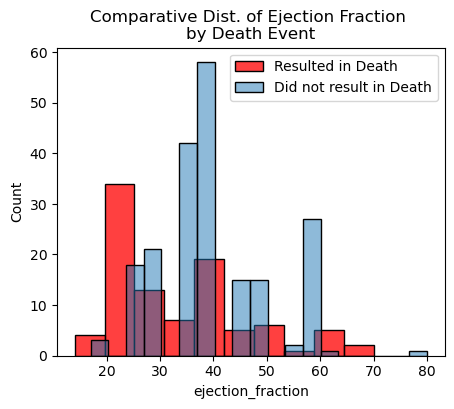

The ejection fraction distribution for patients who died is more right skewed, while 
the ejection fraction of the patients who did not die follows a more normal distribution.


In [8]:
# ejection fraction is the percentage of blood leaving the heart 
# at each contraction (percentage)

plt.figure(figsize = (5,4))

sns.histplot(data = df[df.death_event == 1], x = 'ejection_fraction', label = 'Resulted in Death', color = 'red')
sns.histplot(data = df[df.death_event == 0], x = 'ejection_fraction', label = 'Did not result in Death', alpha = .5)

plt.title("Comparative Dist. of Ejection Fraction \nby Death Event")
plt.legend()

plt.show()

print("The ejection fraction distribution for patients who died is more right skewed, while \
\nthe ejection fraction of the patients who did not die follows a more normal distribution.")

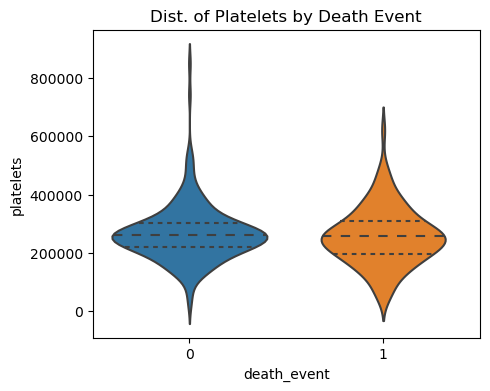

In [9]:
plt.figure(figsize = (5,4))

sns.violinplot(data = df, x = 'death_event', y = 'platelets', inner = 'quartile')
plt.title("Dist. of Platelets by Death Event")

plt.show()

print("")

### Perm Tests

We are writing permutation tests here to determine statistical significance.  If the less than .05 of the permuted differences of the variables of interest fall below .05, then we will add the variable to our machine learning model (pending multicollinearity check)

In [10]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [11]:
def generate_diffs_and_graph(col, len_a, df):
    # generated permuted differences
    actual_diff = group.loc[1][col] - group.loc[0][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

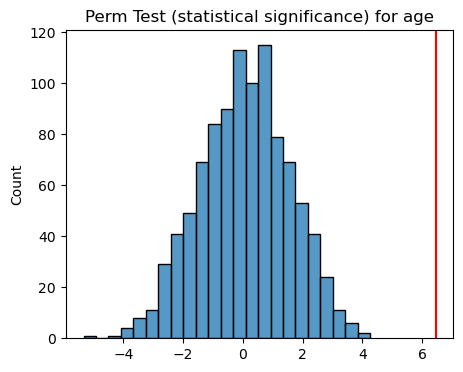

p-val: 0.0


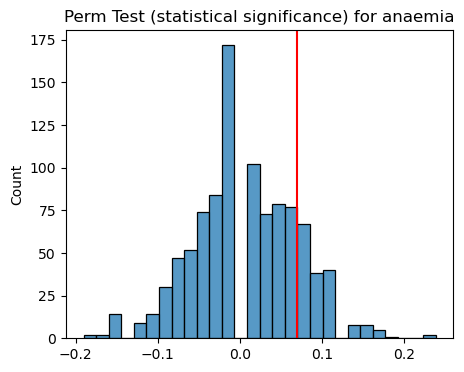

p-val: 0.22


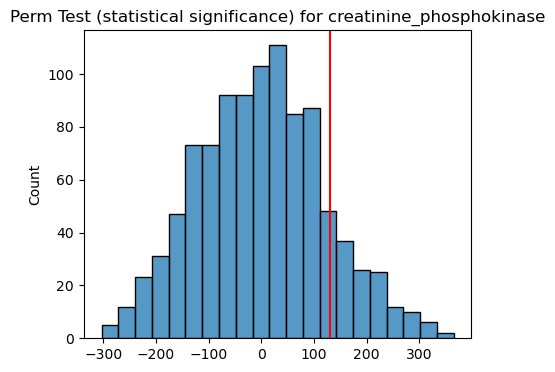

p-val: 0.281


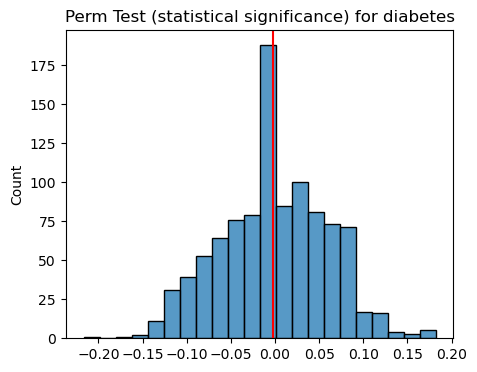

p-val: 0.895


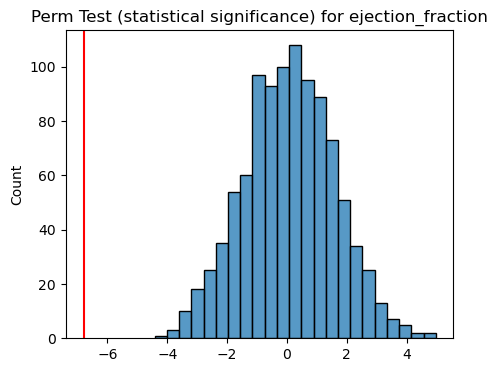

p-val: 0.0


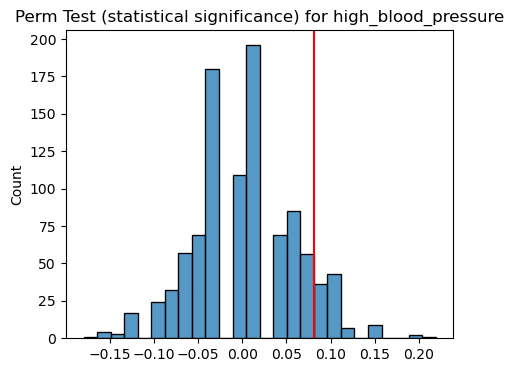

p-val: 0.143


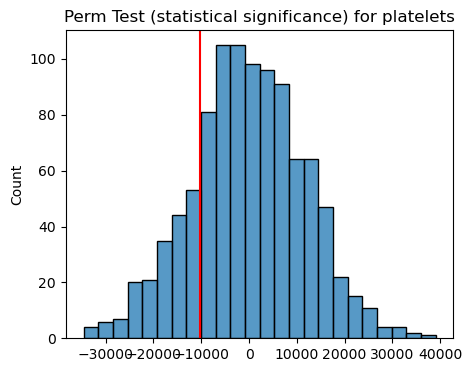

p-val: 0.382


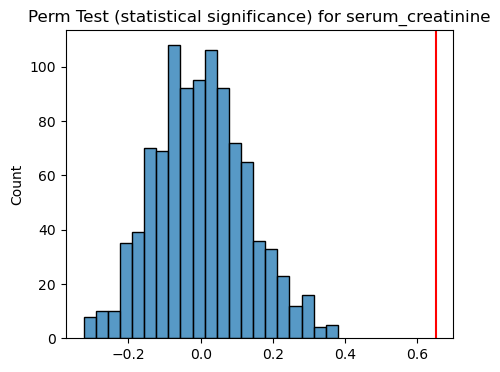

p-val: 0.0


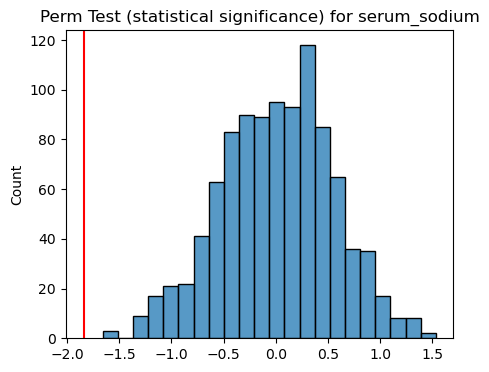

p-val: 0.0


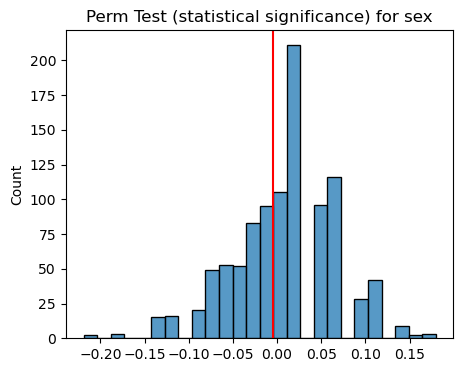

p-val: 0.895


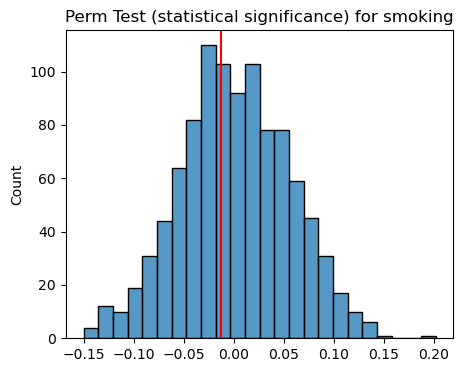

p-val: 0.805


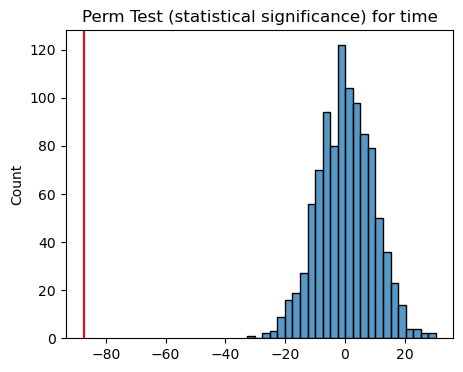

p-val: 0.0


In [12]:
significant_vars = []
len_a = df.death_event.value_counts().loc[1]

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a, df)
    if (p_val <= .05):
        significant_vars.append(col)

## Word of Caution using P-values

P-values can be notoriously misleading.  When looking at p-values, you want to form a hypothesis about what you will find before running a statistical significant test.  If you run enough statistical significance tests then you are bound to find a p-val that meets the general threshold of being below .05.  Therefore, it is critical to understand how the independent variable affects the dependent variable before running a statistical significance test.

But.... since we're just doing an EDA for fun here and I'm not a doctor, we're just going to grab the variables that are below this threshold to build a machine learning model.

In [13]:
significant_vars

['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']

In [14]:
plot_vars = significant_vars.copy()
plot_vars.append('death_event')
plot_vars

['age',
 'ejection_fraction',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'death_event']

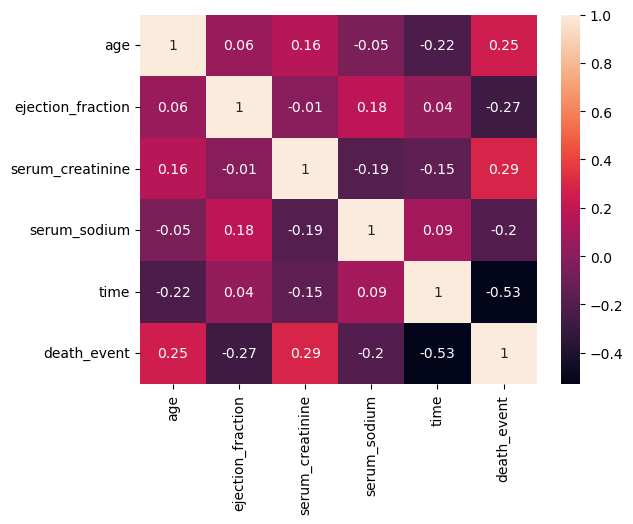

In [15]:
# looking for multicollinearity
plt.figure()
sns.heatmap(df[plot_vars].corr().round(2), annot = True)
plt.show()

### Modeling

In [16]:
significant_vars

['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']

In [17]:
model_df = df.copy()

for col in significant_vars:
    mean = model_df[col].mean()
    std = model_df[col].std()
    
    
    model_df[col] = (model_df[col] - mean) / std
    
model_df[significant_vars]

,age,ejection_fraction,serum_creatinine,serum_sodium,time
0,1.190949,-1.527998,0.489237,-1.501519,-1.626775
1,-0.490457,-0.007065,-0.284076,-0.141739,-1.601007
2,0.350246,-1.527998,-0.090748,-1.728149,-1.588122
3,-0.910808,-1.527998,0.489237,0.084892,-1.588122
4,0.350246,-1.527998,1.262550,-4.674340,-1.575238
...,...,...,...,...,...
294,0.098035,-0.007065,-0.284076,1.444672,1.800432
295,-0.490457,-0.007065,-0.187412,0.538152,1.813317
296,-1.331160,1.851853,-0.574068,0.311522,1.903506
297,-1.331160,-0.007065,0.005916,0.764782,1.929275


In [18]:
predictors = significant_vars.copy()
outcome = 'death_event'

X = model_df[predictors]
y = model_df[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [19]:
X_test

,age,ejection_fraction,serum_creatinine,serum_sodium,time
268,-1.331160,-0.007065,-0.477404,0.764782,1.465442
272,0.518386,-0.007065,-0.187412,-0.821629,1.478326
245,0.013965,-0.007065,0.005916,0.084892,1.066031
10,1.190949,-0.007065,2.519183,-1.274889,-1.549470
120,-0.070106,1.851853,0.102580,-0.368369,-0.454309
...,...,...,...,...,...
109,-1.331160,-0.260554,-0.090748,1.218042,-0.544499
201,-1.331160,1.851853,-0.380740,-0.141739,0.718156
54,-0.070106,-0.007065,0.779229,-1.048259,-1.098521
179,-0.490457,0.161928,-0.670733,0.764782,0.215671


In [20]:
df_test = pd.merge(X_test, y_test, left_index = True, right_index = True)
df_test['LogPred'] = clf.predict(df_test[predictors])
df_test.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time,death_event,LogPred
268,-1.331160,-0.007065,-0.477404,0.764782,1.465442,0,0
272,0.518386,-0.007065,-0.187412,-0.821629,1.478326,0,0
245,0.013965,-0.007065,0.005916,0.084892,1.066031,0,0
10,1.190949,-0.007065,2.519183,-1.274889,-1.549470,1,1
120,-0.070106,1.851853,0.102580,-0.368369,-0.454309,0,0


### Accuracy Metrics for Logistic Regression

In [21]:
log_reg_accuracy = format(accuracy_score(df_test.death_event, df_test.LogPred) * 100, ".1f")
log_reg_precision = format(precision_score(df_test.death_event, df_test.LogPred) * 100, ".1f")
log_reg_recall = format(recall_score(df_test.death_event, df_test.LogPred) * 100, ".1f")

print("Accuracy Score:", log_reg_accuracy)
print("Precision Score:", log_reg_precision)
print("Recall Score:", log_reg_recall)

Accuracy Score: 88.9
Precision Score: 73.9
Recall Score: 81.0


In [22]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 30)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=30)

In [23]:
df_test['RFPrediction'] = rf.predict(df_test[predictors])
df_test.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time,death_event,LogPred,RFPrediction
268,-1.331160,-0.007065,-0.477404,0.764782,1.465442,0,0,0
272,0.518386,-0.007065,-0.187412,-0.821629,1.478326,0,0,0
245,0.013965,-0.007065,0.005916,0.084892,1.066031,0,0,0
10,1.190949,-0.007065,2.519183,-1.274889,-1.549470,1,1,1
120,-0.070106,1.851853,0.102580,-0.368369,-0.454309,0,0,0


### Accuracy Metrics for Random Forest Classifier

In [24]:
rf_accuracy = format(accuracy_score(df_test.death_event, df_test.RFPrediction) * 100, ".1f")
rf_precision = format(precision_score(df_test.death_event, df_test.RFPrediction) * 100, ".1f")
rf_recall = format(recall_score(df_test.death_event, df_test.RFPrediction) * 100, ".1f")

print("Accuracy Score:", rf_accuracy)
print("Precision Score:", rf_precision)
print("Recall Score:", rf_recall)

Accuracy Score: 86.7
Precision Score: 66.7
Recall Score: 85.7


### Use GridSearch CV to look for tune random forest Hyperparameters

In [25]:
params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

In [26]:
clf_cv = GridSearchCV(rf, param_grid = params)
clf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=5,
                                              min_samples_split=30),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [50, 100, 150, 200, 250]})

In [27]:
tuned = clf_cv.best_params_
tuned

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 10,
 'n_estimators': 50}

In [28]:
rf = RandomForestClassifier(n_estimators = tuned['n_estimators'], max_depth = tuned['max_depth'],
                            min_samples_split = tuned['min_samples_split'], criterion = tuned['criterion'])
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=50)

In [29]:
df_test['RFPredCV'] = rf.predict(df_test[predictors])
df_test.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time,death_event,LogPred,RFPrediction,RFPredCV
268,-1.331160,-0.007065,-0.477404,0.764782,1.465442,0,0,0,0
272,0.518386,-0.007065,-0.187412,-0.821629,1.478326,0,0,0,0
245,0.013965,-0.007065,0.005916,0.084892,1.066031,0,0,0,0
10,1.190949,-0.007065,2.519183,-1.274889,-1.549470,1,1,1,1
120,-0.070106,1.851853,0.102580,-0.368369,-0.454309,0,0,0,0


### Accuracy Metrics for Random Forest Classifier

In [30]:
rf_tuned_accuracy = format(accuracy_score(df_test.death_event, df_test.RFPredCV) * 100, ".1f")
rf_tuned_precision = format(precision_score(df_test.death_event, df_test.RFPredCV) * 100, ".1f")
rf_tuned_recall = format(recall_score(df_test.death_event, df_test.RFPredCV) * 100, ".1f")

print("Accuracy Score:", rf_tuned_accuracy)
print("Precision Score:", rf_tuned_precision)
print("Recall Score:", rf_tuned_recall)

Accuracy Score: 86.7
Precision Score: 66.7
Recall Score: 85.7


In [31]:
score_df = pd.DataFrame(data = [[log_reg_accuracy, log_reg_precision, log_reg_recall],
                                [rf_accuracy, rf_precision, rf_recall],
                                [rf_tuned_accuracy, rf_tuned_precision, rf_tuned_recall]],
                        index = ['Logistic Regression', 'Random Forest Classifier', 'Random Forest w/GridSearchCV'],
                        columns = ['Accuracy', 'Precision', 'Recall'])
score_df

,Accuracy,Precision,Recall
Logistic Regression,88.9,73.9,81.0
Random Forest Classifier,86.7,66.7,85.7
Random Forest w/GridSearchCV,86.7,66.7,85.7
